# Collaboration and Competition using ddpg

---

In this notebook, I use the DDPG baseline and some variation of it to train multiples agents to play tennis in a Unity ML-Agents environment. This project correspond to the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

## 1. Naive Approach
### Start the Environment
First, I imports necessary packages. If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
from unityagents import UnityEnvironment
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline
import torch


Before running the next cell, check that the path for the environment is correct. Change the `file_name` parameter to match the location of the Unity environment that you downloaded before.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

In [2]:
env = UnityEnvironment(file_name="/home/raphe/Cours/Nanodegree_DRL/env/Tennis_Linux/Tennis.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# Here we take the brain name  and set it as the default
# Environments contain brains which are responsible for deciding the actions of their associated agents
# We use 2 agents. Depending on the algorythm used to solve the environement
# the agents may collaborate or not. But from a technical point of view one could say that they are indepandant
# as they dont evolve in the same space.
brain_name= env.brain_names


print(brain_name)

['TennisBrain']


### Examine the State and Action Spaces

As I stated in README.MD, the goal of the two agents is to bounce a ball over a net using a racket as long as possible. If the agent hits the ball over the net, it receives a reward of +0.1. But, if the agent lets the ball hit the ground or hit it oustide of the table, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket.
Each agent has only two continuous actions available:
- moving toward or away the net
- jumping. 

In [4]:
brain_name= env.brain_names[0]
brain = env.brains[brain_name]

In [5]:
# reset the environment
 
env_info = env.reset(train_mode=True)[brain_name]


# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

print(action_size,state_size)

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]
2 24


### Take Random Actions in the Environment

In the next code cell, I use the Python API to control the agents and receive feedback from the environment.

As one can see, the comportement of each agent and his performance are really bad. 
This is due to the fact that the agent has not yet learned how to play tennis. I use a random function to define the actions values. 

## Training

In [6]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

class Actor(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, states_size, action_size, seed=0, fc1_units=256, fc2_units=128):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(states_size,fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)      
        self.fc3 = nn.Linear(fc2_units, action_size)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, states):
        """Build an actor (policy) network that maps states -> actions."""
        x  = F.relu(self.fc1(states))
        x  = F.relu(self.fc2(x))  
        x  = torch.tanh(self.fc3(x))
        return x


class Critic(nn.Module):
    """Critic (Value) Model."""

    """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fcs1_units (int): Number of nodes in the first hidden layer
        fc2_units (int): Number of nodes in the second hidden layer
    """
    def __init__(self, states_size, actions_size, seed=0, fc1_units=256, fc2_units=128):
        """Initialize parameters and build model."""
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(states_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units+(actions_size), fc2_units)
        self.fc3 = nn.Linear(fc2_units, 1)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)
        
    def forward(self, states, actions):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        xs = F.relu(self.fc1(states))
        x = torch.cat((xs, actions), dim=1)
        x = F.relu(self.fc2(x))
        return self.fc3(x)
         



### Parameters

In [7]:
import numpy as np
import random
import copy
from collections import namedtuple, deque


import torch
import torch.nn.functional as F
import torch.optim as optim

BUFFER_SIZE = int(1e6)  # replay buffer size
BATCH_SIZE = 128        # minibatch size
GAMMA = 0.99         # discount factor
TAU = 6e-2             # for soft update of target parameters
LR_ACTOR = 1e-3         # learning rate of the actor 
LR_CRITIC = 1e-3        # learning rate of the critic
WEIGHT_DECAY = 0.00     # L2 weight decay
UPDATE_EVERY=1
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Class Noise

In [8]:
class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, mu=0.0, theta=0.13, sigma=0.2):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.size = size
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.standard_normal(self.size)
        self.state = x + dx
        return self.state


### Replay buffer

In [9]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """

        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        random.seed(seed)
   
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
 
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
 
        return states, actions, rewards, next_states, dones

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)


### Class agent 

In [10]:
class Agent():
    """Interacts with and learns from the environment."""
    
    def __init__(self, state_size, action_size,ind,nb_agent ,random_seed=0):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            random_seed (int): random seed
        """
        self.state_size   = state_size[ind]
        self.action_size  = action_size[ind]
        self.states_size  = sum(state_size)
        self.actions_size = sum(action_size)
        
       # self.seed = random.seed(random_seed)
        self.rate=1
        # Actor Network (w/ Target Network)
        self.actor_local = Actor(48, self.action_size).to(device)
        self.actor_target = Actor(48, self.action_size).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=LR_ACTOR)

        # Critic Network (w/ Target Network)
        self.critic_local = Critic(self.states_size, self.actions_size).to(device)
        self.critic_target = Critic(self.states_size, self.actions_size).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)

        # Noise process
        self.noise = OUNoise(self.action_size, random_seed)


    def act(self, states,action_size, add_noise=True,rate=0.99):
        """Returns actions for given state as per current policy."""
        states = torch.from_numpy(states).float().to(device)
        # Determine action value: 
        # We use the network in evaluation mode. (it may differt from training depending of the architecture: dropout, batchnormal)
        self.actor_local.eval() 
        with torch.no_grad():
            action = self.actor_local(states).cpu().data.numpy()
        self.actor_local.train()

        # Epsilon-greedy action selection
        
        """  
        self.rate=rate*self.rate
        
        if random.random() > 0.1*self.rate :
            return np.argmax(action.cpu().data.numpy())
        else:
            return random.choice(np.arange(action_size))
 
        """
        if add_noise:
            self.rate=rate*self.rate
            self.noise_val = self.noise.sample()*self.rate
            action += self.noise_val
        return np.clip(action, -1, 1)
      
    def reset(self):
        self.noise.reset()
       
    def learn(self,states, actions,next_states,next_actions, actions_pred,\
               reward,done,gamma):
 
        """Update policy and value parameters using given batch of experience tuples.
        Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value

        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        # ---------------------------- update critic ---------------------------- #

        # Compute Q targets for current states (y_i)

        with torch.no_grad():
            Q_targets_next = self.critic_target(next_states, next_actions) 
            #for i in range(BATCH_SIZE):
            #print("Q_targets",Q_targets_next)
            Q_targets_next=reward+gamma*Q_targets_next*(1-done)
            #print( "reward", reward)
            #print( "gamma" , gamma)          
            Q_targets = Q_targets_next #reward  + (gamma * Q_targets_next.squeeze(1) * (1 - done))
            #print("Q",Q_targets)

        # Compute Q experted using the critic
        Q_expected = self.critic_local(states,actions)
        #print("Q_expected",Q_expected-Q_targets)
        # Compute critic loss
        critic_loss = F.mse_loss(Q_expected, Q_targets)


        # Minimize the loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward() 
        self.critic_optimizer.step()

        # ---------------------------- update actor ---------------------------- #
        # Compute actor loss       
        actor_loss = -self.critic_local(states, actions_pred).mean()
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()
        
        # ----------------------- update target networks ----------------------- #
        self.soft_update(self.critic_local, self.critic_target, TAU)
        self.soft_update(self.actor_local,self.actor_target, TAU)                     

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)                

In [11]:
class maddpg:

    def __init__(self, state_size, action_size,nb_agent=1 ,random_seed=0):
            # Replay memory
        self.memory = ReplayBuffer( BUFFER_SIZE, BATCH_SIZE, random_seed)
 
    def add_buffer(self,states, actions, rewards, next_states, dones):
        self.memory.add(states, actions, rewards, next_states, dones)

    def sample_buffer(self):
        states, actions, rewards, next_states, dones = self.memory.sample()
        return states.to(device).detach(),actions.to(device).detach(),rewards.to(device).detach(),next_states.to(device).detach(), dones.to(device).detach()   
  
    def step(self,agent,nb_agent):
            if(BATCH_SIZE< len(self.memory)):

                for id_agent in range(nb_agent):
                    next_actions = [] 
                    actions_pred=[]
                    states, actions, rewards,next_states,dones=MADDPG.sample_buffer()
                   # print("actions",actions)
                    tmp_states      = states.view(BATCH_SIZE,nb_agent,24)
                    tmp_actions     = actions.view(BATCH_SIZE,nb_agent,2)
                    tmp_next_states = next_states.view(BATCH_SIZE,nb_agent,24)
                    ref_next_actions=[]
                    ref_actions_pred=[]
                    
                    for i in range(nb_agent):
                        if(i==id_agent):
                            ref_next_actions.append(agent[id_agent].actor_target(next_states))  
                            ref_actions_pred.append(agent[id_agent].actor_local(states))

                    #    else:
                    #         ref_next_actions.append(tmp_actions[:,i,:])
                             #ref_next_actions.append(agent[id_agent].actor_target(next_states))  
                    #         ref_actions_pred.append(tmp_actions[:,i,:])
                    #ref_next_actions=torch.cat(ref_next_actions,dim=1)
                    #ref_actions_pred=torch.cat(ref_actions_pred,dim=1)

                    next_actions = agent[id_agent].actor_target(next_states)
                    if id_agent == 0:
                        next_actions = torch.cat((next_actions, actions[:,2:]), dim=1)
                    else:
                        next_actions = torch.cat((actions[:,:2], next_actions), dim=1)                    
    
                    actions_pred = agent[id_agent].actor_local(states)
        
                    if id_agent == 0:
                        actions_pred = torch.cat((actions_pred, actions[:,2:]), dim=1)
                    else:
                        actions_pred = torch.cat((actions[:,:2], actions_pred), dim=1)
                    
                    # reward=rewards.view(BATCH_SIZE,nb_agent)[:,id_agent]
                    # done=dones.view(BATCH_SIZE,nb_agent)[:,id_agent]                   
                    # print("states tmp", states.shape(), tmp_states.shape())
                    # print("action tmp", actions.shape(), tmp_actions.shape())
                    # print("next_s tmp", next_states.shape(), tmp_next_states.shape())
                    # print("rewar-done", reward.shape(), tmp_reward.shape())
                    #print("actions_pred\n",next_actions)
                    #print("ref actions_pred\n",ref_next_actions)
                    
                    agent[id_agent].learn(states,\
                                   actions,\
                                   next_states,\
                                   next_actions,\
                                   actions_pred,\
                                   np.reshape(rewards[:,id_agent],(BATCH_SIZE,1)),\
                                   np.reshape(dones[:,id_agent],(BATCH_SIZE,1)),\
                                   GAMMA)


In [12]:
nb_agent=2
print(state_size)
print(action_size)
state_size =np.array([24, 24])
action_size =np.array([2,2]) # first Goal keeper , than striker

 
agent =[Agent(state_size, action_size,i,nb_agent ,random_seed=0) for i in range(nb_agent)]
MADDPG = maddpg(state_size, action_size,nb_agent ,random_seed=0)

24
2


In [13]:
def multi_ddpg(env, env_info, state_size, action_size, brain_name,nb_agent, agent,MADDPG,n_episodes=10, max_t=20):
    scores_deque = deque(maxlen=100)
    scores = []
    iteration=0
    dc=0.9999

    #random_actions_g = np.random.random_sample(2) * 4
    #random_actions_s = np.random.random_sample(2) * 5       
    #next_state, reward= env.step(action)    
    
    for i_episode in range(1, n_episodes):
        env_info= env.reset(train_mode=True)[brain_name] # reset the environment       
        [agent[i].reset() for i in range(nb_agent)] # reset the noise added to the state. Makes the training more robust.
        score=np.zeros(2)  # initialize the score (for each agent)
        states  = env_info.vector_observations
        states = np.concatenate((states[0],states[1]),axis=0)
        states = np.reshape(states, (1, 48))
        #print("reshape",states)        
        dones=[False]
        add_noise=False
        for t in range(max_t):         
            if(t>6):
                add_noise=True
            # actions = agent.act(states)
            action_0 = agent[0].act(states,action_size[0],add_noise,0.999)
            action_1 = agent[1].act(states,action_size[1],add_noise,0.999)
            actions  = np.concatenate((action_0,action_1),axis=0)
            actions  = np.reshape(actions, (1, 4))

            env_info = env.step(actions)[brain_name]
            
            next_states = env_info.vector_observations
            next_states = np.reshape(next_states,(1,48))
            rewards     = env_info.rewards
            dones       = env_info.local_done
            
            

            #states = np.concatenate((states[0],states[1]),axis=0)
            
            
            MADDPG.add_buffer(states, actions, rewards,next_states, dones)
            MADDPG.step(agent,nb_agent)

            states = next_states # roll over the state to next time step
            score += rewards                                  # update the score (for each agent)
            if any(dones):
                break
            #states = np.reshape(states, (1, 48))   
        scores.append(np.max(score)) # save the best agent score for display
        scores_deque.append(np.max(score)) # save the best agent score into the windows for convergence checking
      #  print('Episode {}\t Average Score: {:.4E}\t: reward:{} critic:{:.4E}\t actor:{:.4E}\t'.format(i_episode, np.mean(scores_deque), np.max(score),critic,actor), end="")
        if i_episode>100 and np.mean(scores_deque)>5.: # check if env is solved
            print("envionment solved")
            [torch.save(agent[i].actor_local.state_dict(), 'multi_checkpoint_actor'+str(i)+'.pth') for i in range(num_agents)] # save actor weights for each agents
            [torch.save(agent[i].critic_local.state_dict(), 'multi_checkpoint_critic'+str(i)+'.pth') for i in range(num_agents)] # save critic weights for each agents
            return scores
        
        if (i_episode%10==0):
            print('E {}\t A Score: {}\t: R max : {}\t\n'.format(i_episode, np.mean(scores_deque), score), end="")
      #  else:
           # print('E {}\t A Score: {:.4E}\t: R0__{:.4E}\t R1__{:.4E}\t\n'.format(i_episode, np.mean(scores_deque), score[0],score[1]), end="")

        #    [torch.save(agent.actor_local[i].state_dict(), 'multi_checkpoint_actor'+str(i)+'.pth') for i in range(num_agents)] # save actor weights for each agents
        #    [torch.save(agent.critic_local[i].state_dict(), 'multi_checkpoint_critic'+str(i)+'.pth') for i in range(num_agents)] # save critic weights for each agents
   
    return scores

In [14]:
scores = multi_ddpg(env, env_info, state_size, action_size, brain_name,num_agents, agent,MADDPG,500,1000000)

E 10	 A Score: 0.0	: R max : [-0.01  0.  ]	
E 20	 A Score: 0.0	: R max : [ 0.   -0.01]	
E 30	 A Score: 0.0	: R max : [ 0.   -0.01]	
E 40	 A Score: 0.005000000074505806	: R max : [ 0.   -0.01]	
E 50	 A Score: 0.00800000011920929	: R max : [-0.02  0.1 ]	
E 60	 A Score: 0.0066666667660077415	: R max : [ 0.   -0.01]	
E 70	 A Score: 0.005714285799435207	: R max : [-0.01  0.  ]	
E 80	 A Score: 0.005000000074505806	: R max : [-0.01  0.  ]	
E 90	 A Score: 0.004444444510671827	: R max : [-0.01  0.  ]	
E 100	 A Score: 0.004000000059604645	: R max : [ 0.   -0.01]	
E 110	 A Score: 0.005000000074505806	: R max : [-0.01  0.  ]	
E 120	 A Score: 0.006900000106543303	: R max : [ 0.   -0.01]	
E 130	 A Score: 0.007800000123679638	: R max : [ 0.   -0.01]	
E 140	 A Score: 0.006800000108778476	: R max : [-0.01  0.  ]	
E 150	 A Score: 0.005800000093877315	: R max : [-0.01  0.  ]	
E 160	 A Score: 0.005800000093877315	: R max : [ 0.   -0.01]	
E 170	 A Score: 0.010800000168383122	: R max : [ 0.1  -0.01]	
E 180	

In [15]:
#Episode 1972	Average Score: 0.5029000074975193	Score: 1.0000000149011612envionment solved

## Display results for training

##### Score

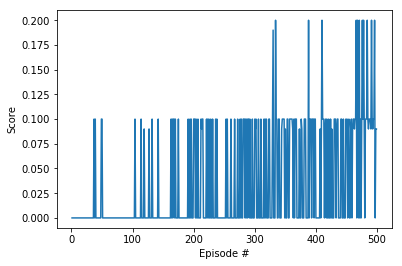

In [16]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

#### End of training

In [17]:
#env.close()

### 2. Test

#### Load libraries

In [18]:
from unityagents import UnityEnvironment
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline
import torch
 

#### Define testing function

In [19]:
def ddpg_Test(env,brain_name,num_agents,agent,file_name_actor,file_name_critic,n_episodes=6000, max_t=1000):
    """ Visualize agent using saved checkpoint. """
    # load saved weights
    agent.actor_local.load_state_dict(torch.load(file_name_actor))
    agent.critic_local.load_state_dict(torch.load(file_name_critic)) 
    scores = []  # list containing scores from each episode
 
    for i_episode in range(1, n_episodes):
        env_info = env.reset(train_mode=False)[brain_name]  # environment informations
        states = env_info.vector_observations 
        agent.reset()
        score = np.zeros(num_agents) 
        for t in range(max_t):
            actions = agent.act(states,rate=0.9999) # get action using the DDPG algorythme (for each agent)
            env_info = env.step(actions)[brain_name]  # update environment informations with the actions of each agent
            next_states = env_info.vector_observations  # get next state (for each agent)
            rewards = env_info.rewards  # get reward (for each agent)
            dones = env_info.local_done  # see if episode finished
            states = next_states  # roll over the state to next time step
            score =score+ rewards  # update the score for each agent
            if any(dones):  # see if episode has finished
                break
        print('\rEpisode {}\tAverage Score: {}, touch: {}'.format(i_episode, np.max(score),t), end="")
        scores.append(np.max(score)) # save the best score between both agents

    return scores



In [20]:
def double_ddpg_Test(env,brain_name,num_agents,agent,file_name_actor,file_name_critic,n_episodes=6000, max_t=1000):
    """ Visualize agent using saved checkpoint. """
    # load saved weights
    for i in range(num_agents):
        agent.actor_local[i].load_state_dict(torch.load(file_name_actor[i]))
        agent.critic_local[i].load_state_dict(torch.load(file_name_critic[i])) 
        
    scores = []                        # list containing scores from each episode
    score = 0
 
    for i_episode in range(1, n_episodes):
        env_info = env.reset(train_mode=False)[brain_name]
        states = env_info.vector_observations 
        agent.reset() 
        score = np.zeros(num_agents) 
        for t in range(max_t):
            actions = [agent.act(states[i],rate=0.95,ind=i) for i in range(nb_agent)] # get action from each agent based on the current state
            env_info = env.step(actions)[brain_name] 
            next_states = env_info.vector_observations         # get next state (for each agent)
            rewards = env_info.rewards                         # get reward (for each agent)
            dones = env_info.local_done                        # see if episode finished
            #agent.step(states, actions, rewards, next_states, dones,num_agents)
            states = next_states
            score =score+ rewards
            if any(dones):
                break
        scores.append(np.max(score)) # save the best score between both agents
    print('\rEpisode {}\tAverage Score: {}'.format(i_episode, np.max(score)), end="")
    return scores

#### Load environment

In [21]:
#env = UnityEnvironment(file_name="/home/raphe/Cours/Nanodegree_DRL/Tennis_Linux/Tennis.x86_64")

In [22]:
# reset the environment
env_info = env.reset(train_mode=False)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])
nb_agent=2

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.19835949 -1.5
 -0.          0.         -7.85035563  5.94114017 -0.          0.        ]


In [23]:
agent =Agent(state_size=state_size, action_size=action_size,nb_agent=2, random_seed=1234)

TypeError: __init__() missing 1 required positional argument: 'ind'

#### Define the weights

In [ ]:
file_name_actor=[]
file_name_critic=[]
for i in range(num_agents):
    file_name_actor.append('multi_checkpoint_actor'+str(i)+'.pth')
    file_name_critic.append('multi_checkpoint_critic'+str(i)+'.pth')

#### Load the weight, start testing

In [ ]:
scores=double_ddpg_Test(env,brain_name,num_agents,agent,file_name_actor,file_name_critic ,n_episodes=20,max_t=100)

 #### Display score

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

#### End of testing

In [ ]:
env.close()